In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import time
from sklearn import svm
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
import nltk
from nltk.corpus import stopwords
import xgboost as xgb

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
train_data = []  # 16659
test_data = []  # 810

In [5]:
'''读取文件'''
print('Reading files...')
print('\n')
train_f = open("train.txt", encoding='utf-8')
for line in train_f:
    train_data.append(line)
train_f.close()

test_f = open("test.txt", encoding='utf-8')
for line in test_f:
    test_data.append(line)
test_f.close()
print(train_data[0])
print(test_data[0])
print('\n')
print('Files get!...')

Reading files...


" 5 . Science includes such diverse fields as astronomy , biology , computer sciences , geology , logic , physics , chemistry , and mathematics ( [ link ] ) ."	"0"

" 2 . It becomes clear from this definition that the application of the scientific method plays a major role in science ."	"0"



Files get!...


In [6]:
'''去掉开头序号-> [[句子(单词间以,为分割)], 0/1]'''
print('Formatting...')
print('\n')
train_set = []
for unit in train_data:
    temp = unit.split(' ')
    if temp[1].isdigit():
        # 判断第一个字符是否为数字，如果是则去掉，如果不是则取句子
        temp = temp[3:-1]
        # 当前temp中的最后一部分为"\t.\n","最后一个引号" 为了保证格式规范，先去掉，最后在取corpus的时候加上句号即可
        # training_set.append(([temp, unit[-3:-2]]))
        train_set.append([' '.join(temp), unit[-3:-2]])
        # unit[-3:-2]为当前句子的label
    else:
        # temp[1]为引号，应去掉
        temp = temp[1:-1]
        # training_set.append(([temp, unit[-3:-2]]))
        train_set.append([' '.join(temp), unit[-3:-2]])

test_set = []
for unit in test_data:
    temp = unit.split(' ')
    if temp[1].isdigit():
        temp = temp[3:-1]
        # training_set.append(([temp, unit[-3:-2]]))
        test_set.append([' '.join(temp), unit[-3:-2]])
    else:
        temp = temp[1:-1]
        # training_set.append(([temp, unit[-3:-2]]))
        test_set.append([' '.join(temp), unit[-3:-2]])

print(train_set[0])
print(test_set[0])
print('\n')
print('All data sets are formatted!')

Formatting...


['Science includes such diverse fields as astronomy , biology , computer sciences , geology , logic , physics , chemistry , and mathematics ( [ link ] )', '0']
['It becomes clear from this definition that the application of the scientific method plays a major role in science', '0']


All data sets are formatted!


In [7]:
print('Tokenizeing...')
print('\n')

def tokenize(data):
    res = []
    for samples in data:
        # nltk.word_tokenize用于取tokens
        temp_t = nltk.word_tokenize(samples[0])
        res.append([temp_t, samples[1]])
    return res


train_set = tokenize(train_set)
test_set = tokenize(test_set)
print(train_set[0])
print(test_set[0])
print('\n')
print('Tokenization completed!')

Tokenizeing...


[['Science', 'includes', 'such', 'diverse', 'fields', 'as', 'astronomy', ',', 'biology', ',', 'computer', 'sciences', ',', 'geology', ',', 'logic', ',', 'physics', ',', 'chemistry', ',', 'and', 'mathematics', '(', '[', 'link', ']', ')'], '0']
[['It', 'becomes', 'clear', 'from', 'this', 'definition', 'that', 'the', 'application', 'of', 'the', 'scientific', 'method', 'plays', 'a', 'major', 'role', 'in', 'science'], '0']


Tokenization completed!


In [8]:
print('Removing stopwords...')
print('\n')
stop_words = set(stopwords.words("english"))
# stop_words为英文所有stop words的集合


def Remove_stopwords(data):
    res = []
    temp = []
    for sets in data:
        for w in sets[0]:
            # 如果对于句子中任意一个单词不属于stop_words则将其加入新的dataset
            if w not in stop_words:
                temp.append(w)
        res.append([temp, sets[1]])
        temp = []

    return res


train_set = Remove_stopwords(train_set)
test_set = Remove_stopwords(test_set)
print(train_set[0])
print(test_set[0])
print('\n')
print('Stopwords removed!')

Removing stopwords...


[['Science', 'includes', 'diverse', 'fields', 'astronomy', ',', 'biology', ',', 'computer', 'sciences', ',', 'geology', ',', 'logic', ',', 'physics', ',', 'chemistry', ',', 'mathematics', '(', '[', 'link', ']', ')'], '0']
[['It', 'becomes', 'clear', 'definition', 'application', 'scientific', 'method', 'plays', 'major', 'role', 'science'], '0']


Stopwords removed!


In [9]:
print('Stemming...')
print('\n')
ps = PorterStemmer()


def Stemming(data):
    res = []
    stemmed_words_temp = []
    for units in data:
        for w in units[0]:
            #ps.stem(w):对当前单词w取stem word
            stemmed_words_temp.append(ps.stem(w))

        res.append([stemmed_words_temp, units[1]])
        stemmed_words_temp = []
    return res


train_set = Stemming(train_set)
test_set = Stemming(test_set)
print(train_set[0])
print(test_set[0])
print('\n')
print('Stemming completed!')

Stemming...


[['scienc', 'includ', 'divers', 'field', 'astronomi', ',', 'biolog', ',', 'comput', 'scienc', ',', 'geolog', ',', 'logic', ',', 'physic', ',', 'chemistri', ',', 'mathemat', '(', '[', 'link', ']', ')'], '0']
[['It', 'becom', 'clear', 'definit', 'applic', 'scientif', 'method', 'play', 'major', 'role', 'scienc'], '0']


Stemming completed!


In [10]:
print('Lemmatization...')
print('\n')
lem = WordNetLemmatizer()
stem = PorterStemmer()


def Lemmatization(data):
    lem_words_temp = []
    res = []
    for atoms in data:
        for w in atoms[0]:
            #lem.lemmatize(w, "v"): 对当前单词w取Lemmatization
            lem_words_temp.append(lem.lemmatize(w, "v"))
        res.append([lem_words_temp, atoms[1]])
        lem_words_temp = []

    return res


train_set = Lemmatization(train_set)
test_set = Lemmatization(test_set)
print(train_set[0])
print(test_set[0])
print('\n')
print('Lemmatization completed!')

Lemmatization...


[['scienc', 'includ', 'divers', 'field', 'astronomi', ',', 'biolog', ',', 'comput', 'scienc', ',', 'geolog', ',', 'logic', ',', 'physic', ',', 'chemistri', ',', 'mathemat', '(', '[', 'link', ']', ')'], '0']
[['It', 'becom', 'clear', 'definit', 'applic', 'scientif', 'method', 'play', 'major', 'role', 'scienc'], '0']


Lemmatization completed!


In [11]:
print('Corpus and labels gathering...')
print('\n')
corpus_test = []
corpus_train = []


def Gathering_corpus(data):
    res = []
    temp_res = []
    for aas in data:
        #corpus中仅仅需要第一个unit，即句子
        temp_res.append(aas[0])

    for aaas in temp_res:
        # 对于scikit-learn中的vectorizer，corpus必须为一句一句话的集合，而并非tokens。所以这里必须join然后加上句号。
        temp_ff = ' '.join(aaas)
        temp_ff = temp_ff + '.'
        res.append(temp_ff)
    return res


corpus_train = Gathering_corpus(train_set)
corpus_test = Gathering_corpus(test_set)
# train和test的corpus之和，成为corpus_sum
corpus_sum = []
corpus_sum = corpus_train
for things in corpus_test:
    corpus_sum.append(things)
print('len of corpus_sum:', len(corpus_sum))
print(corpus_sum[:5])
#取出label: Y_train and Y_test
Y_train = []
for thing in train_set:
    Y_train.append(thing[1])
Y_train = np.array(Y_train)
Y_test = []
for that in test_set:
    Y_test.append(that[1])
Y_test = np.array(Y_test)
print(Y_train[:5])
print(Y_test[:5])
print(Y_train.shape)
print(Y_test.shape)
print('\n')
print('Corpus and labels get!')

Corpus and labels gathering...


len of corpus_sum: 17469
['scienc includ divers field astronomi , biolog , comput scienc , geolog , logic , physic , chemistri , mathemat ( [ link ] ).', 'howev , field scienc relat physic world phenomena process consid natur scienc.', 'thu , museum natur scienc might contain item list.', 'In deduct reason , pattern think move opposit direct compar induct reason.', 'deduct reason form logic think use gener principl law forecast specif result.']
['0' '1' '0' '0' '1']
['0' '1' '0' '1' '1']
(16659,)
(810,)


Corpus and labels get!


In [12]:
print('tfidf processing...')
print('\n')
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(corpus_sum)
X_train_tfidf = X_tfidf[:16659]
X_test_tfidf = X_tfidf[16659:17469]
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()
X_tfidf_arr = X_tfidf.toarray()
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_tfidf_arr.shape)
print('\n')
print('tfidf get!')

tfidf processing...


(16659, 14675)
(810, 14675)
(17469, 14675)


tfidf get!


In [0]:
def Format_into_array(data):
    res = []
    for items in data:
        temp = int(items)
        res.append(temp)
    res = np.array(res)
    
    return res

In [14]:
Y_test = Format_into_array(Y_test)
Y_train = Format_into_array(Y_train)
print(Y_test[:10])
print(Y_train[:10])

[0 1 0 1 1 1 0 0 1 0]
[0 1 0 0 1 0 0 1 1 1]


In [0]:
dtrain=xgb.DMatrix(X_train_tfidf,label=Y_train)
dtest=xgb.DMatrix(X_test_tfidf, label=Y_test)

In [0]:
params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth':15,
        'lambda':8,
        'alpha':8,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':1.25,
        'eta': 0.025,
        'gamma':0.2,
        'learning_rate' : 0.02}

In [0]:
watchlist = [(dtrain,'train'), (dtest,'test')]

In [18]:
bst=xgb.train(params,dtrain,num_boost_round=800,evals=watchlist)

[0]	train-auc:0.620743	test-auc:0.600204
[1]	train-auc:0.657211	test-auc:0.633533
[2]	train-auc:0.673636	test-auc:0.65694
[3]	train-auc:0.678212	test-auc:0.661387
[4]	train-auc:0.682134	test-auc:0.666922
[5]	train-auc:0.686379	test-auc:0.675896
[6]	train-auc:0.690094	test-auc:0.679596
[7]	train-auc:0.692024	test-auc:0.683856
[8]	train-auc:0.69277	test-auc:0.685544
[9]	train-auc:0.694619	test-auc:0.690783
[10]	train-auc:0.695034	test-auc:0.690142
[11]	train-auc:0.698854	test-auc:0.695149
[12]	train-auc:0.701834	test-auc:0.696851
[13]	train-auc:0.703361	test-auc:0.70065
[14]	train-auc:0.703705	test-auc:0.702335
[15]	train-auc:0.704213	test-auc:0.701482
[16]	train-auc:0.704291	test-auc:0.703007
[17]	train-auc:0.704258	test-auc:0.703754
[18]	train-auc:0.704598	test-auc:0.705145
[19]	train-auc:0.704561	test-auc:0.704716
[20]	train-auc:0.704729	test-auc:0.704842
[21]	train-auc:0.714208	test-auc:0.713893
[22]	train-auc:0.715803	test-auc:0.716039
[23]	train-auc:0.717702	test-auc:0.7155
[24]	tr

In [0]:
def Curve_for_hat(data, cutoff):
    res = []
    for items in data:
        if items >= cutoff:
            temp = 1
        else:
            temp = 0
        res.append(temp)
    res = np.array(res)
    
    return res

In [0]:
Y_hat=bst.predict(dtest)

In [0]:
Y_hat = Curve_for_hat(Y_hat,0.3)

In [63]:
print('Scores of XGB:\n')
print('F1 score:', f1_score(Y_test, Y_hat, average='binary', pos_label=1))
print('Precision:', precision_score(Y_test, Y_hat, average='binary', pos_label=1))
print('Recall:', recall_score(Y_test, Y_hat, average='binary', pos_label=1))
print('Accuracy:', accuracy_score(Y_test, Y_hat))

Scores of XGB:

F1 score: 0.6312500000000001
Precision: 0.5504087193460491
Recall: 0.73992673992674
Accuracy: 0.7086419753086419


In [0]:
import matplotlib
import matplotlib.pyplot as plt

In [0]:
xgb.plot_tree(bst, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(120, 120)
fig.savefig('/content/drive/My Drive/tree.png')

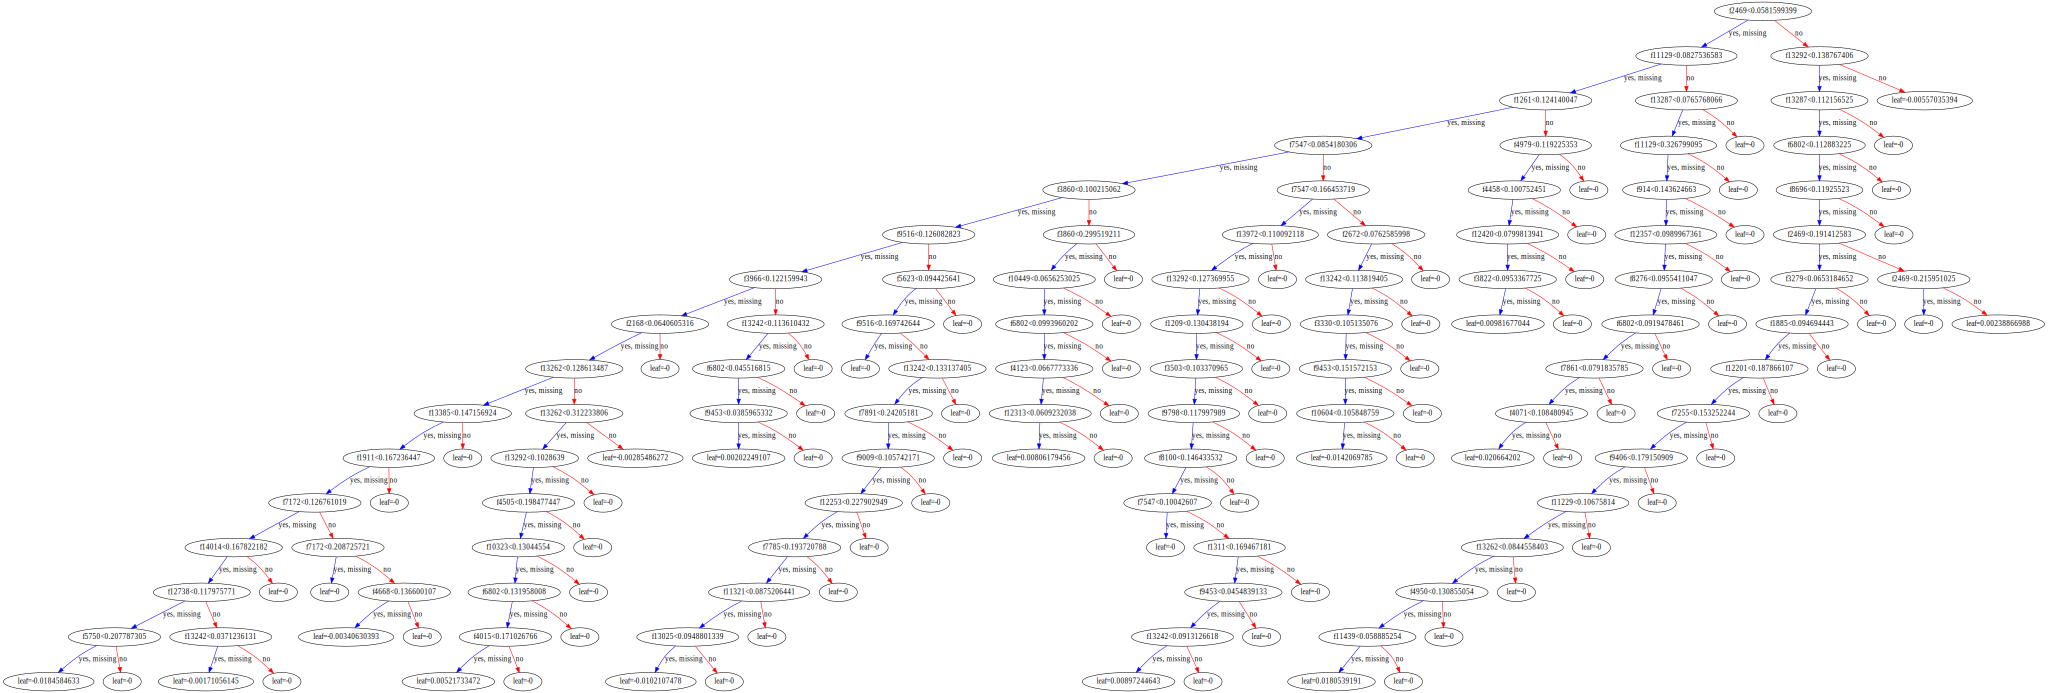

In [47]:
xgb.to_graphviz(bst, num_trees=3)

In [54]:
print(len(Y_hat))

810


In [0]:
error_list = []
for i in range(len(Y_hat)):
    if Y_hat[i] != Y_test[i]:
        error_list.append(i)

In [56]:
print(len(error_list))

236


In [0]:
check_data = []  # 810

In [35]:
'''读取文件'''
print('Reading files...')
print('\n')

test_f = open("test.txt", encoding='utf-8')
for line in test_f:
    check_data.append(line)
test_f.close()
print(check_data[0])
print('\n')
print('Files get!...')

Reading files...


" 2 . It becomes clear from this definition that the application of the scientific method plays a major role in science ."	"0"



Files get!...


In [37]:
'''去掉开头序号-> [[句子(单词间以,为分割)], 0/1]'''
print('Formatting...')
print('\n')

check_set = []
for unit in check_data:
    temp = unit.split(' ')
    if temp[1].isdigit():
        temp = temp[3:-1]
        # training_set.append(([temp, unit[-3:-2]]))
        check_set.append([' '.join(temp), unit[-3:-2]])
    else:
        temp = temp[1:-1]
        # training_set.append(([temp, unit[-3:-2]]))
        check_set.append([' '.join(temp), unit[-3:-2]])

print(check_set[0])
print('\n')
print('All data sets are formatted!')

Formatting...


['It becomes clear from this definition that the application of the scientific method plays a major role in science', '0']


All data sets are formatted!


In [57]:
#Here are those sentences this model made mistakes at
for index in error_list:
    print('\n')
    print('Sentence is below:')
    print(check_set[index])



Sentence is below:
['Glycogen is the animal equivalent of starch and is a highly branched molecule usually stored in liver and muscle cells', '0']


Sentence is below:
['DNA and RNA are made up of monomers known as nucleotides', '0']


Sentence is below:
['The nucleotides combine with each other to form a polynucleotide , DNA or RNA', '1']


Sentence is below:
['If you examine [ link]b , the diagram of a plant cell , you will see a structure external to the plasma membrane called the cell wall', '0']


Sentence is below:
['In the early twentieth century , biologists in a field of study known as population genetics began to study how selective forces change a population through changes in allele and genotypic frequencies', '0']


Sentence is below:
['Consequently , all of these organisms also have amniotic eggs and make a single clade , also called a monophyletic group', '0']


Sentence is below:
['Seedless plants have historically played a role in human life through uses as tools , f

In [0]:
import pickle
file_name = "/content/drive/My Drive/800_tfidf.pkl"

# save
pickle.dump(bst, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [69]:
xgb_model_loaded.predict(dtrain)

array([0.26235506, 0.1936129 , 0.187475  , ..., 0.18115395, 0.18597141,
       0.1147385 ], dtype=float32)